In [2]:
from sklearn.preprocessing import normalize

def get_pos_mean(df, scorer, individual, bodyparts):
    n_data = len(df)
    data = df[scorer][individual]
    n_bodyparts = len(bodyparts)
    pos_mean = np.zeros((n_data, 3))

    for bp in bodyparts:
        pos_mean += df[scorer][individual][bp].values 
    return pos_mean/n_bodyparts


def get_ori_mean(df, scorer, individual, bodyparts):
    n_data = len(df)
    data = df[scorer][individual]
    n_bodyparts = len(bodyparts)
    n_pairs = int(n_bodyparts/2)
    ori_mean = np.zeros((n_data, 3))

    for i in range(n_pairs):
        bp_h = bodyparts[i]
        bp_t = bodyparts[-(i+1)]
        if not bp_h == bp_t:
            ori_mean += normalize((df[scorer][individual][bp_h].values - df[scorer][individual][bp_t].values), axis = 1)
    return normalize(ori_mean, axis = 1)

In [3]:
import pandas as pd
import numpy as np
from glob import glob


def get_trajectory(file_path, nan_method = 'drop'):
    
    '''
    This function will take the file(obtained from trangulation) that containes the trajectories of the markers. 
    Markers of the same object will be used to compute the position and orientation of each object at each frame.
    
    file_path: path to the file that containes the 3D trajectories of the makers.
    
    nan_method: method to deal with the Nans in the dataframe. Options: 'drop', 'fill'
                'drop': This will just drop all the rows that contain Nans
                'fill': This will fill the Nans from previous non-Nan value if applicable. If there is no previous 
                        non-Nan value, it will fill the Nans from the following non-Nan value.
    '''
        
    df = pd.read_hdf(file_path)
    if nan_method == 'fill':
        df = df.fillna(method = 'ffill').fillna(method = 'bfill') # get rid of NaNs
    elif nan_method == 'drop':
        df = df.dropna()
    scorer = df.columns.get_level_values('scorer').unique()[0]
    individuals = df.columns.get_level_values('individuals').unique()

    df_new = pd.DataFrame()

    for individual in individuals:
        bodyparts = df[scorer][individual].columns.get_level_values('bodyparts').unique()
        n_bp = len(bodyparts)
        if individual != 'single':
            # this is an individual
            pos_mean = get_pos_mean(df, scorer, individual, bodyparts)
            ori_mean = get_ori_mean(df, scorer, individual, bodyparts)
            pose_mean = np.concatenate((pos_mean, ori_mean), axis = 1)
            pdindex = pd.MultiIndex.from_product(
                        [[individual], ["x", "y", "z", "X", "Y","Z"]],
                        names=["individuals","pose"],
                    )
            frame = pd.DataFrame(pose_mean, columns=pdindex)
            df_new = pd.concat([frame, df_new], axis=1)
        elif individual == 'single':
            # these are the unique objects(pitcher, cup etc there is only one of which in the scene)
            uniques = set([bp.split('_')[0] for bp in bodyparts])
            for unique in uniques:
                bodyparts_u = [bp for bp in bodyparts if bp.split('_')[0] == unique]
                pos_mean = get_pos_mean(df, scorer, individual, bodyparts_u)
                ori_mean = get_ori_mean(df, scorer, individual, bodyparts_u)
                pose_mean = np.concatenate((pos_mean, ori_mean), axis = 1)
                pdindex = pd.MultiIndex.from_product(
                            [[unique], ["x", "y", "z", "X", "Y","Z"]],
                            names=["individuals","pose"],
                        )
                frame = pd.DataFrame(pose_mean, columns=pdindex)
                df_new = pd.concat([frame, df_new], axis=1)
    return df_new

In [86]:
files = glob('../camera-main/videos/1641421641/*_3D.h5')
file = files[0]
df_new = get_trajectory(file, nan_method = 'fill')

In [29]:
def get_velocity(x):  
    v = np.zeros_like(x)
    for i, data in enumerate(x):
        if i == 0:
            v[i] = np.nan
        else:
            v[i] = x[i] - x[i - 1]
    return v

def get_acceleration(v):
    a = np.zeros_like(v)
    for i, data in enumerate(v):
        if i == 0 or i == 1:
            a[i] = np.nan
        else:
            a[i] = v[i] - v[i - 1]
    return a
    
    

In [39]:
x = df_new['pitcher']['x'].values
v_forward = get_velocity(x)
a_forward = get_acceleration(v)

x_flip = np.flip(x)
v_flip = get_velocity(x_flip)
a_flip = get_acceleration(v_flip)
v_backward = np.flip(v_flip)
a_backward = np.flip(a_flip)

x_diff_forward = np.zeros_like(x)
for i , data in enumerate(x):
    if i <= 2:
        pass
    else:
        x_diff_forward[i] = v_forward[i - 1] + 0.5 * a[i - 1]

In [52]:
x_diff = np.zeros_like(x)
for i , data in enumerate(x):
    if i <= 2:
        pass
    else:
        x_diff[i] = 1.5 * x[i - 1] - 2 * x[i - 2] + 0.5 * x[i - 3]

In [72]:
def get_distance(x):
    x_diff = np.zeros_like(x)
    for i , data in enumerate(x):
        if i <= 1:
            pass
        else:
            x_diff[i] = 1.5 * x[i] - 2 * x[i - 1] + 0.5 * x[i - 2]
    return x_diff

def get_x_prime(x, x_diff):
    
    x_p = np.roll(x + x_diff, 1)
    x_p[0:3] = np.nan
    return x_p
    

In [97]:
def get_x_p_average(x):
    x_dist_f = get_distance(x)
    x_p_f = get_x_prime(x, x_dist_f)

    x_flip = np.flip(x)
    x_dist_flip = get_distance(x_flip)
    x_p_b = np.flip(get_x_prime(x_flip, x_dist_flip))

    x_p_average = (x_p_f + x_p_b) / 2
    return x_p_average
    

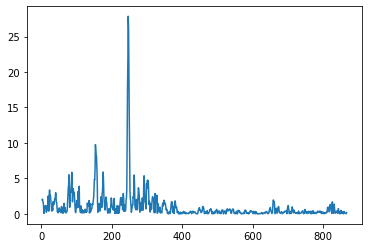

In [129]:
obj = 'pitcher'

x = df_new[obj]['x'].values
y = df_new[obj]['y'].values
z = df_new[obj]['z'].values

x_p_average = get_x_p_average(x)
y_p_average = get_x_p_average(y)
z_p_average = get_x_p_average(z)

error = np.sqrt((x - x_p_average)**2 + (y - y_p_average)**2 + (z - z_p_average)**2)

from matplotlib import pyplot as plt

plt.plot(error)